In [1]:
import math
import random
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.data import TensorDataset, DataLoader
from board import Board
from agent import Agent
# set white background
plt.rcParams['figure.facecolor'] = 'white'

In [2]:
board = Board()

print(board)


% E % 
% . % 
. P . 


In [3]:


def get_best_action(board, agent):
    pp = board.get_position(2)
    tp = board.get_position(3)
    
    best_action = None
    best_value = -math.inf
    
    for a in range(board.get_total_actions()):
        board_copy = board.copy()
        board_copy.do_action(pp, tp, a)
        
        with torch.no_grad():
            agent.eval()
            value, _ = agent(board_copy.to_tensor())
        
        if value > best_value:
            best_value = value.item()
            best_action = a
            
    return best_action




def evaluate(policy, n=100, max_steps=20):
    
    v = 0
    fh = []
    for _ in range(n):
        board = Board()
        pp = board.get_position(2)
        tp = board.get_position(3)
        ah = []
        for _ in range(max_steps):
            value, pl = agent(board.to_tensor())
            
            a = get_best_action(board, policy)
            board.do_action(pp, tp, a)
            pp = board.get_position(2)
            tp = board.get_position(3)
            if pl.argmax() == a:
                ah.append(1)
            else:
                ah.append(0)
            if board.is_win():
                fh.extend(ah)
                v += 1
                break
        
    return v / n, sum(fh) / (len(fh) if len(fh) > 0 else 1)




  0%|          | 0/12000 [00:00<?, ?it/s]

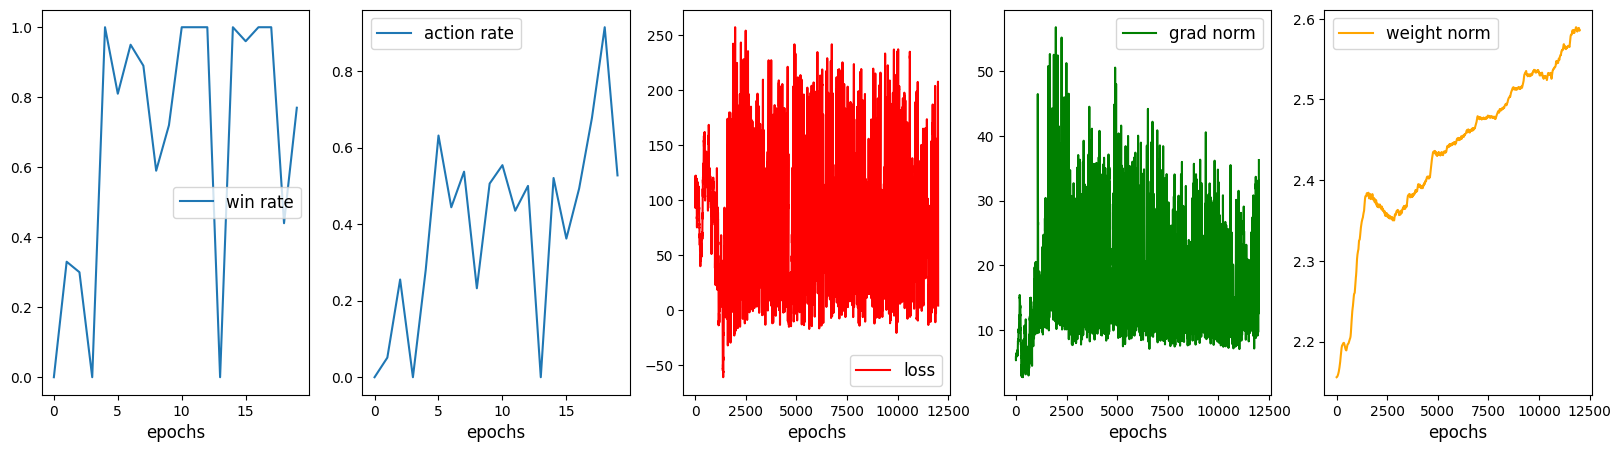

In [4]:

lh = []
agent = Agent(45, board.get_total_actions())
# agent.load_state_dict(torch.load('bagent.pt'))
optimizer = optim.AdamW(agent.parameters(), lr=0.00001, weight_decay=0.01)
crit = nn.MSELoss()

mem_size = 150
boards_memory = []
actions_memory = []
rewards_memory = []

epochs = 12000
data_points = 20

best_value = -math.inf

lq = []
gq = []
wq = []

actq = []

for e in tqdm(range(epochs)):

    if e % (epochs / data_points) == 0:
        value, act = evaluate(agent)
        if value > best_value:
            best_value = value
            torch.save(agent.state_dict(), 'bagent.pt')
        lh.append(value)
        actq.append(act)

    board = Board()

    pp = board.get_position(2)
    tp = board.get_position(3)

    boards = []
    actions = []
    rewards = []

    for _ in range(20):
        if random.random() < 0.1:
            a = random.randint(0, board.get_total_actions() - 1)
        else:
            a = get_best_action(board, agent)

        pp = board.get_position(2)
        tp = board.get_position(3)

        bc = board.copy()
        boards.append(bc)
        actions.append(a)
        board.do_action(pp, tp, a)

        if board.is_win():
            rewards.append(15)
            break

        elif board.board[1][1] == 4 and board.board[0][1] != 3:
            rewards.append(-5)
            break
        else:
            rewards.append(-1)

    acc_reward = 0
    agent.train()
    for b, a, r in reversed(list(zip(boards, actions, rewards))):
        acc_reward += r
        boards_memory.append(b.to_tensor().unsqueeze(0))
        actions_memory.append(torch.Tensor([a]).unsqueeze(0))
        rewards_memory.append(torch.Tensor([acc_reward]).unsqueeze(0))

    if len(boards_memory) > mem_size:
        boards_memory = boards_memory[len(boards_memory) - mem_size:]
        actions_memory = actions_memory[len(actions_memory) - mem_size:]
        rewards_memory = rewards_memory[len(rewards_memory) - mem_size:]

    el = []
    gl = []
    ws = []
    for b, a, r in DataLoader(TensorDataset(torch.cat(boards_memory), torch.cat(actions_memory), torch.cat(rewards_memory)), batch_size=32,
                           shuffle=True):
        optimizer.zero_grad()
        pred, pol = agent(b)
        l1 = crit(pred, r)
        cat = Categorical(pol)
        l2 = torch.mean(-cat.log_prob(a.squeeze(1)).unsqueeze(1) * r)
        loss = l1 + l2
        loss.backward()
        for p in agent.parameters():
            if p.grad is not None:
                gl.append(p.grad.data.norm(2).item())
            ws.append(p.data.norm(2).item())
        optimizer.step()
        el.append(loss.item())
        

    lq.append(sum(el) / len(el))
    gq.append(sum(gl) / len(gl))
    wq.append(sum(ws) / len(ws))

fig, ax = plt.subplots(1, 5, figsize=(20, 5))

ax[0].plot(lh, label='win rate')
ax[1].plot(actq, label='action rate')
ax[2].plot(lq, label='loss', color='red')
ax[3].plot(gq, label='grad norm', color='green')
ax[4].plot(wq, label='weight norm', color='orange')

# add title for each subplot
for i in range(5):
    ax[i].set_title(ax[i].get_xlabel(), fontsize=14)
    ax[i].set_xlabel('epochs', fontsize=12)
    ax[i].legend(fontsize=12)

plt.show()
